In [1]:
import sys, os

import numpy as np
import argparse
import pickle

from pyeit.mesh import PyEITMesh
import pyeit.mesh as mesh
from pyeit.eit.interp2d import sim2pts
from pyeit.eit.protocol import PyEITProtocol
from pyeit.visual.plot    import create_mesh_plot, create_plot
from pyeit.mesh.shape import *
from pyeit.mesh.utils import edge_list
from pyeit.mesh import PyEITMesh
sys.path.insert(0, r"C:\Users\boulette\OneDrive\Bureau\Final push\Project_EIT_CT_2025\src")  # TO adapt
sys.path.insert(0, r"C:\Users\boulette\OneDrive\Bureau\Final push\Project_EIT_CT_2025\src_aatae") # TO adapt


In [2]:
def load_mesh_pkl(path):
    """
    Load a mesh from a pickle file.
    Parameters
    ----------
    path : str
        Path to the pickle file containing the mesh data.   
    Returns
    -------
    mesh : PyEITMesh
        The loaded mesh object.
    mask : np.ndarray               
        The mask of the mesh.
    boundary_edges : np.ndarray
    """
    with open(path,"rb") as f:
        d = pickle.load(f)
    mesh = PyEITMesh(node=d["node"],
                     element=d["element"],
                     el_pos=d["el_pos"])
    mesh.perm = d["perm"]
    return mesh, d["mask"],d["boundary_edges"],d["present_organs"],d["slice_number"],d["z_min"],d["z_max"]



In [3]:
## Adapt the path to your mesh file
case = "s0011"
slice_number =  0
meshA,maskA,barsA,present_organsA,z,z_min,z_max = load_mesh_pkl(f"Slices_folder/{case}/{case}_mesh_slice_{slice_number}.pkl")


In [5]:
print(f"torso zone of subject {case} is limited by slice z_min: {z_min}, and  z_max: {z_max}")


torso zone of subject s0011 is limited by slice z_min: 203, and  z_max: 414


In [6]:
print(f"present organs in the mesh: {present_organsA}")

present organs in the mesh: ['adrenal_gland', 'atrial_appendage', 'autochthon', 'aorta', 'brachiocephalic_trunk', 'brachiocephalic_vein', 'clavicula', 'colon', 'common_carotid_artery', 'costal_cartilages', 'duodenum', 'esophagus', 'gallbladder', 'heart', 'humerus', 'iliopsoas', 'inferior_vena_cava', 'kidney', 'lung', 'pancreas', 'pulmonary_vein', 'portal_and_splenic_vein', 'ribs', 'scapula', 'small_bowel', 'spinal_cord', 'spleen', 'sternum', 'stomach', 'subclavian_artery', 'superior_vena_cava', 'thyroid_gland', 'trachea', 'vertebrae', 'liver']


In [7]:
print(f" slice number: {slice_number}")

 slice number: 0


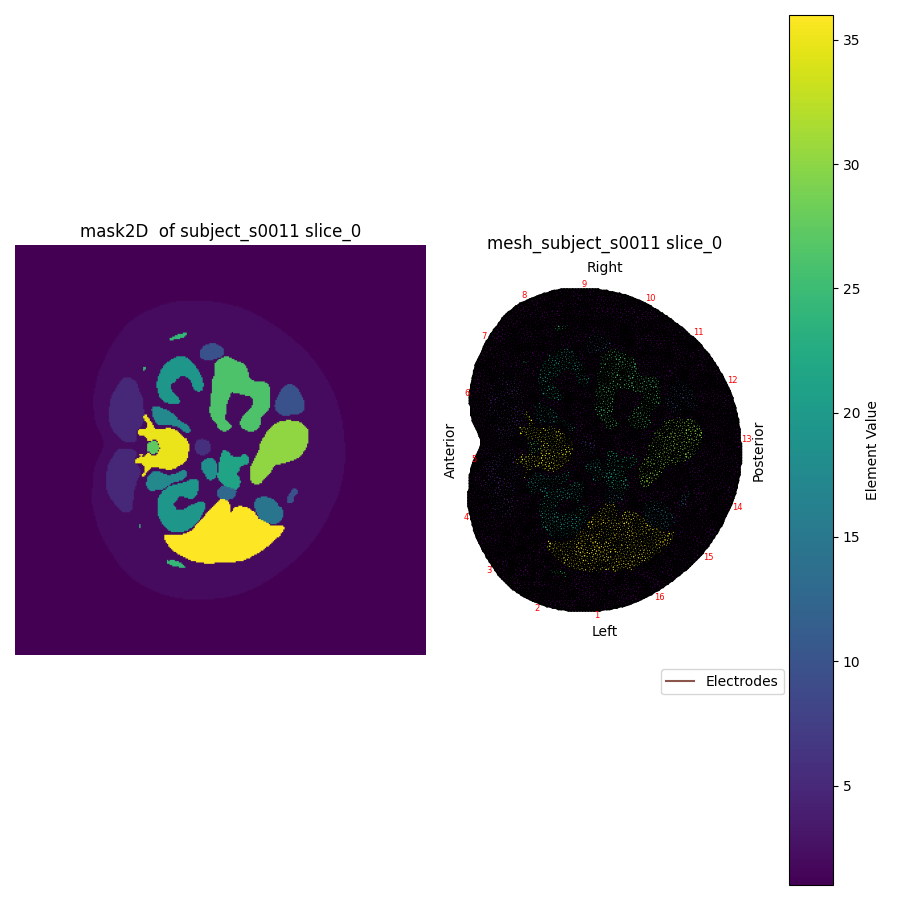

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(9, 9))

ax0.imshow(maskA, cmap='viridis')
ax0.set_title(f"mask2D  of subject_{case} slice_{slice_number}")
ax0.axis("off")
  
create_mesh_plot(
                    ax1,meshA,
                    electrodes=meshA.el_pos,
                    coordinate_labels="radiological",
                    marker_text_kwargs={"color": "red", "fontsize": 6}
)
ax1.set_title(f"mesh_subject_{case} slice_{slice_number}")
ax1.axis("off")

plt.tight_layout()
plt.show()

In [9]:
print(f"boundary edges of the mesh: {barsA}")

boundary edges of the mesh: [[ 11  12]
 [ 41  42]
 [ 69  70]
 [ 74  75]
 [ 83  84]
 [ 56  57]
 [333 334]
 [304 305]
 [114 115]
 [209 210]
 [141 142]
 [143 144]
 [144 145]
 [124 125]
 [175 176]
 [161 162]
 [162 163]
 [191 192]
 [195 196]
 [202 203]
 [210 211]
 [221 222]
 [232 233]
 [229 230]
 [228 229]
 [256 257]
 [249 250]
 [253 254]
 [254 255]
 [ 59  60]
 [267 268]
 [279 280]
 [276 277]
 [268 269]
 [288 289]
 [315 316]
 [  5   6]
 [314 315]
 [332 333]
 [309 310]
 [325 326]
 [341 342]
 [137 138]
 [257 258]
 [185 186]
 [113 114]
 [132 133]
 [100 101]
 [ 82  83]
 [122 123]
 [ 26  27]
 [ 17  18]
 [293 294]
 [280 281]
 [133 134]
 [170 171]
 [265 266]
 [128 129]
 [103 104]
 [ 87  88]
 [186 187]
 [ 63  64]
 [323 324]
 [ 25  26]
 [336 337]
 [337 338]
 [115 116]
 [320 321]
 [139 140]
 [331 332]
 [260 261]
 [190 191]
 [177 178]
 [235 236]
 [140 141]
 [112 113]
 [200 201]
 [  4   5]
 [  7   8]
 [ 22  23]
 [207 208]
 [212 213]
 [ 10  11]
 [197 198]
 [ 51  52]
 [308 309]
 [305 306]
 [151 152]
 [28

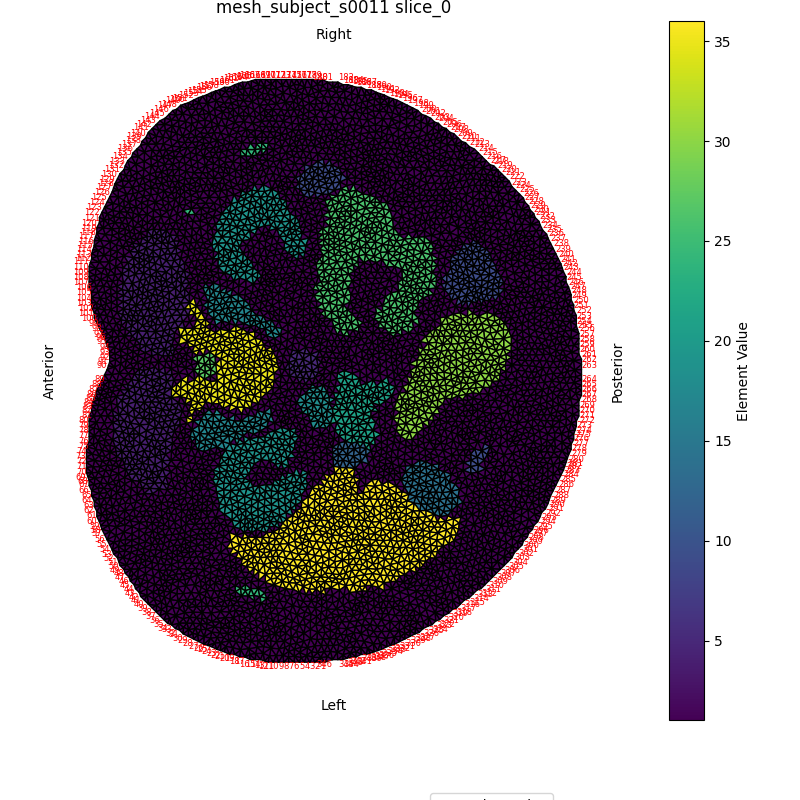

In [5]:
%matplotlib widget

fig, ax0 = plt.subplots(1, 1, figsize=(8,8))



create_mesh_plot(
                    ax0,meshA,
                    electrodes=np.arange(len(barsA)),
                    coordinate_labels="radiological",
                    marker_text_kwargs={"color": "red", "fontsize": 6}
)
ax0.set_title(f"mesh_subject_{case} slice_{slice_number}")
ax0.axis("off")

plt.tight_layout()
plt.show()

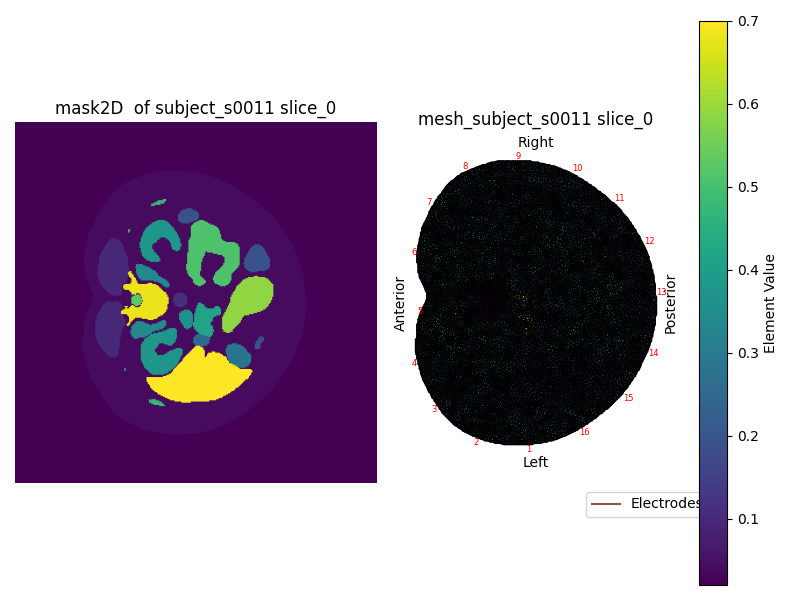

In [6]:
def sig_update(org_list, sig):

    # conductivity lookup
    cond_table = {
        'soft_tissue': 0.30,
        'adrenal_gland': 0.25,
        'autochthon': 0.40,
        'clavicula': 0.02,
        'costal_cartilages': 0.08,
        'ribs': 0.05,
        'scapula': 0.02,
        'sternum': 0.02,
        'skull': 0.02,
        'humerus': 0.02,
        'femur': 0.02,
        'vertebrae': 0.02,
        'sacrum': 0.02,
        'gluteus_maximus': 0.40,
        'gluteus_minimus': 0.40,
        'gluteus_medius': 0.40,
        'iliopsoas': 0.40,
        'hip': 0.08,
        'iliac_arterie': 0.70,
        'iliac_vein': 0.70,
        'brachiocephalic_trunk': 0.70,
        'brachiocephalic_vein': 0.70,
        'common_carotid_artery': 0.70,
        'subclavian_artery': 0.70,
        'aorta': 0.70,
        'superior_vena_cava': 0.70,
        'inferior_vena_cava': 0.70,
        'portal_and_splenic_vein': 0.70,
        'pulmonary_vein': 0.70,
        'trachea': 0.15,
        'lung': 0.15,
        'heart': 0.50,
        'atrial_appendage': 0.20,
        'esophagus': 0.40,
        'stomach': 0.40,
        'duodenum': 0.40,
        'small_bowel': 0.40,
        'colon': 0.40,
        'liver': 0.20,
        'gallbladder': 0.15,
        'pancreas': 0.15,
        'spleen': 0.20,
        'thyroid_gland': 0.50,
        'kidney': 0.35,
        'kidney_cyst': 1.50,
        'urinary_bladder': 1.50,
        'prostate': 0.35,
        'spinal_cord': 0.30,
    }

    # build master list
    master_names = ['soft_tissue'] + list(org_list)

    master_values = []
    for name in master_names:
        if name not in cond_table:
            raise ValueError(f"No conductivity defined for '{name}'")
        master_values.append(cond_table[name])
    master_values = np.array(master_values)

    # --- Adjust labels (1-based → 0-based) ---
    sig_idx = np.asarray(sig, dtype=int) - 1  

    # check for out-of-range
    if sig_idx.max() >= len(master_values) or sig_idx.min() < 0:
        raise IndexError("Some labels in 'sig' exceed available mapping")

    sigma_real = master_values[sig_idx]

    return sigma_real

sig_real = sig_update(present_organsA, meshA.perm)
meshA.perm =sig_real

%matplotlib widget

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 6))

ax0.imshow(maskA, cmap='viridis')
ax0.set_title(f"mask2D  of subject_{case} slice_{slice_number}")
ax0.axis("off")
  
create_mesh_plot(
                    ax1,meshA,
                    electrodes=meshA.el_pos,
                    coordinate_labels="radiological",
                    marker_text_kwargs={"color": "red", "fontsize": 6}
)
ax1.set_title(f"mesh_subject_{case} slice_{slice_number}")
ax1.axis("off")

plt.tight_layout()
plt.show()


EIT_sim -> FOUND


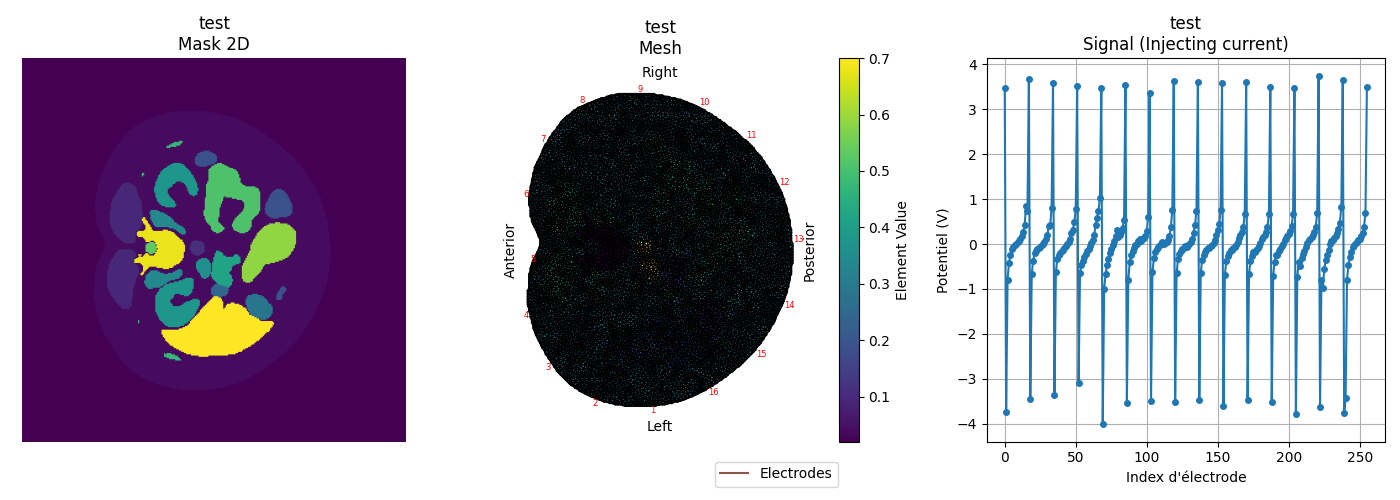

In [ ]:
## Example of solving a forward problem with EIT_sim module,with CEM ##

import importlib.util
for mod in ["EIT_sim"]:
    print(mod, "->", "FOUND" if importlib.util.find_spec(mod) else "NOT FOUND")

from EIT_sim import solve_and_plot, set_protocol


protocol_ref = set_protocol(n_el=meshA.n_el,
                                dist_exc=1,
                                step_meas=1)

    # Solve & Plot de la référence
sol_ref = solve_and_plot(
        meshA,barsA, maskA,
        meshA.perm, protocol_ref,
        1e-5, "current",
        title="test"
)

